# NELDER-MEAD METHOD

## 2-D Implementation

In [1]:
import numpy as np


def sort_state(state, fun):
    xs = np.array([state["best"], state["lousy"], state["worst"]])
    fs = np.array([fun(xs[0]), fun(xs[1]), fun(xs[2])])
    ind = np.argsort(fs)
    state["best"] = xs[ind[0]]
    state["lousy"] = xs[ind[1]]
    state["worst"] = xs[ind[2]]

    return state


def shrink(state, fun):
    state["lousy"] = 0.5 * (state["best"] + state["lousy"])
    state["worst"] = 0.5 * (state["best"] + state["worst"])

    return sort_state(state, fun)


def nelder_mead2d(fun, x1, x2, x3,
                   const_x_R = 2, const_x_E = 3,
                     eps_step = 0.01, eps_fun = 0.01,n_iter = 1000):

    states = []

    # Assign classes to the initial 3 points
    state = {"best": x1, "lousy": x2, "worst": x3}
    state = sort_state(state, fun)

    
    # Apply Nelder-Mead iterations
    for i in range(n_iter):

        # Save each state
        states.append(state.copy())

        # Calculate XR and XE
        x_average = 0.5 * (state["best"] + state["lousy"])
    
        x_R =  state["worst"] + const_x_R * (x_average - state["worst"])
        x_E = state["worst"] +  const_x_E * (x_average - state["worst"])
        
        # Condition 1
        y_R = fun(x_R)
        y_E = fun(x_E)
 
        if y_R < fun(state["best"]):
            # Update with x_E or x_R
            state["worst"] = state["lousy"]
            state["lousy"] = state["best"]
            if y_E < y_R:
                state["best"] = x_E

            else:
                state["best"] = x_R

        # Condition 2
        elif y_R < fun(state["lousy"]):
  
            state["worst"] = state["lousy"]
            state["lousy"] = x_R

        
        # Condition 3
        elif y_R < fun(state["worst"]):
            
            x_oc = state["worst"] + 3/2 * (x_average - state["worst"])
            y_oc = fun(x_oc)
            if y_oc < y_R:
                state["worst"] = x_oc

            # Else shrink
            else:   
                state = shrink(state, fun)

        # Condition 4
        else:
            
            x_ic = state["worst"] + 1/2 * (x_average - state["worst"])
            y_ic = fun(x_ic)
            if y_ic < fun(state["worst"]):
                state["worst"] = x_ic
                state = sort_state(state, fun)
            else:
                state = shrink(state, fun)


        # Convergence
        max_len = np.max([np.linalg.norm(state["best"] - state["worst"])])
                          #np.linalg.norm(state["lousy"] - state["worst"]),
                          # np.linalg.norm(state["best"] - state["lousy"])])
        
        fun_dif = fun(state["best"]) - fun(state["worst"])
        if (fun_dif < eps_fun and max_len < eps_step):
            print(i)
            return states

    return states


## Generalized to arbitrary dimensions

In [9]:
from tqdm import tqdm

def sort_points_and_vals(points, fun_vals):
    ind = np.argsort(fun_vals)
    points = np.array(points)[ind]
    fun_vals = np.array(fun_vals)[ind]
    return list(points), list(fun_vals)


def shrink_gen(points, fun_vals, fun):
    for i, point in enumerate(points[1:]):
        points[i] = 0.5 * (points[0] + point)
        fun_vals[i] = fun(points[i])
    
    return sort_points_and_vals(list(points), list(fun_vals))


def nelder_mead(fun, x_start, 
                const_x_R = 2, const_x_E = 3, start_point_r = 1,
                     eps_step = 0.01, eps_fun = 0.01,n_iter = 10):
    # Saving the best point in each step
    best_points = []

    # Initialize the first collection of points == dim + 1
    points = []
    fun_vals = []
    points.append(x_start)
    fun_vals.append(fun(x_start))


    for i in range(len(x_start)):
        new_point = x_start.copy()

        # Change each point a bit
        new_point[i] += start_point_r
        points.append(new_point)
        fun_vals.append(fun(new_point))

    print(points)

    points, fun_vals = sort_points_and_vals(points, fun_vals)

    # Nelder mead iterations
    for i in tqdm(range(n_iter)):

        # Save the best point
        best_points.append(points[0])
        
        # Calculate XR and XE
        x_average = np.mean(points[:-1], axis=0) # all but the worst point

        x_R = points[-1] + const_x_R * (x_average - points[-1])
        x_E = points[-1] + const_x_E * (x_average - points[-1])

        # Condition 1
        y_R = fun(x_R)
        y_E = fun(x_E)

        if y_R < fun_vals[0]:

            # Update with x_E or x_R
            points.pop(-1)
            fun_vals.pop(-1)

            if y_E < y_R:
                points.insert(0, x_E)
                fun_vals.insert(0, y_E)
            else:
                points.insert(0, x_R)
                fun_vals.insert(0, y_R)

        # Condition 2
        elif y_R < fun_vals[-2]:

            points[-1] = x_R
            fun_vals[-1] = y_R
            points, fun_vals = sort_points_and_vals(points, fun_vals)

        # Condition 3
        elif y_R < fun_vals[-1]:
            
            x_oc = points[-1] + 3/2 * (x_average - points[-1])
            y_oc = fun(x_oc)
            if y_oc < y_R:
                points[-1] = x_oc
                fun_vals[-1] = y_oc

            # Else shrink
            else:
                points, fun_vals = shrink_gen(points, fun_vals, fun)

        # Condition 4
        else:
            x_ic = points[-1] + 1/2 * (x_average - points[-1])
            y_ic = fun(x_ic)
            if y_ic < fun_vals[-1]:
                points[-1] = x_ic
                fun_vals[-1] = y_ic 
                points, fun_vals = sort_points_and_vals(points, fun_vals)

            else:
                points, fun_vals = shrink_gen(points, fun_vals, fun)

        # Convergence
        max_len = np.linalg.norm(points[0] - points[-1])
        fun_diff = fun_vals[0] - fun_vals[-1]

        # if(fun_diff < eps_fun and max_len < eps_step):
        if(max_len < eps_step):
            print(f"Converged in {i} steps")
            return best_points

    return best_points


### Test on a simple 2-d function

48


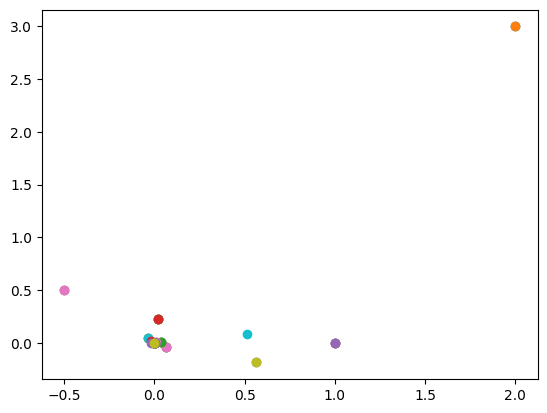

[[2, 3], [4, 3], [2, 5]]


 96%|█████████▌| 48/50 [00:00<00:00, 14514.21it/s]

Converged in 48 steps


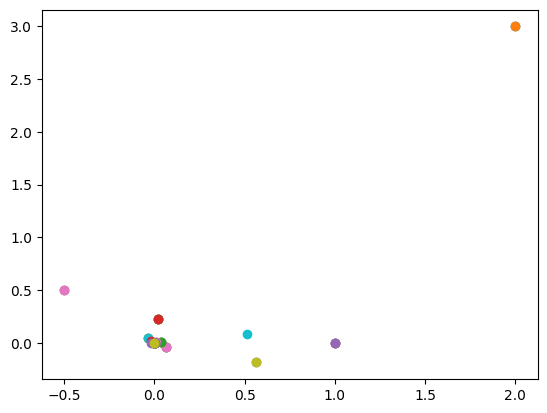

In [3]:
import matplotlib.pyplot as plt

def f(x):
    return x[0]**2 + x[1]**2

# # With 2D implementation
states = nelder_mead2d(f, [2,3], [4,3], [2,5], n_iter=50, eps_step=0.0001, eps_fun=10)
 
alpha = 1
for i, state in enumerate(states):
    # plt.scatter([state["best"][0], state["lousy"][0], state["worst"][0]],[state["best"][1], state["lousy"][1], state["worst"][1]], alpha=alpha)
    plt.scatter([state["best"][0]],[state["best"][1]], alpha=alpha)

plt.savefig("report/figures/convergence_2d.png")
plt.show()


# With the general 
best_points = nelder_mead(f, [2,3], n_iter=50,  eps_step=0.0001, eps_fun=10)

plt.figure()
for point in best_points:
    plt.scatter(point[0], point[1])
plt.savefig("report/figures/convergence_alld.png")
    

## Use nelder mead on the 3 functions

In [7]:
# Function 1
def f1(x):
    return (x[0] - x[2])**2 + (2*x[1] + x[2])**2 + (4*x[0] - 2*x[1] + x[2])**2 + x[0] + x[1]

# Function 2 
def f2(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2 + 100* (x[1] - x[0]**2)**2 + 100* (x[2] - x[1]**2)**2

# Function 3
def f3(x):
    return (1.5 - x[0] + x[0] * x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0] * x[1]**3)**2


In [34]:
# Function 1
start_point = [0,0,0]
best_points = nelder_mead(f1, start_point, n_iter=100000, eps_fun=1e-7, eps_step=1e-8, start_point_r=5)
print(f1(best_points[-1]), best_points[-1])

start_point = [1,1,0]
best_points = nelder_mead(f1, start_point, n_iter=100000, eps_fun=1e-7, eps_step=1e-8, start_point_r=5)
print(f1(best_points[-1]), best_points[-1])

[[0, 0, 0], [5, 0, 0], [0, 5, 0], [0, 0, 5]]


  0%|          | 138/100000 [00:00<00:05, 17272.87it/s]


Converged in 138 steps
-0.1979166666666666 [-0.16666666 -0.22916666  0.16666666]
[[1, 1, 0], [6, 1, 0], [1, 6, 0], [1, 1, 5]]


  0%|          | 132/100000 [00:00<00:04, 24806.14it/s]

Converged in 132 steps
-0.19791666666666646 [-0.16666666 -0.22916667  0.16666667]


In [37]:
# Function 2
start_point = [1.2,1.2,1.2]
best_points = nelder_mead(f2, start_point, n_iter=100000, eps_fun=1e-7, eps_step=1e-7, start_point_r=5)
print(f2(best_points[-1]), best_points[-1])

start_point =  [-1,1.2,1.2]
best_points = nelder_mead(f2, start_point, n_iter=100000, eps_fun=1e-7, eps_step=1e-7, start_point_r=5)
print(f2(best_points[-1]), best_points[-1])

[[1.2, 1.2, 1.2], [6.2, 1.2, 1.2], [1.2, 6.2, 1.2], [1.2, 1.2, 6.2]]


  0%|          | 123/100000 [00:00<00:05, 18123.35it/s]


Converged in 123 steps
7.339486143598763 [-1.45794794  2.1347794   4.56158427]
[[-1, 1.2, 1.2], [4, 1.2, 1.2], [-1, 6.2, 1.2], [-1, 1.2, 6.2]]


  0%|          | 102/100000 [00:00<00:05, 19941.22it/s]

Converged in 102 steps
2.3250924856747153 [-0.13926095  0.04574354 -0.01961921]


In [43]:
# Function 3
start_point = [1,1]
best_points = nelder_mead(f3, start_point, n_iter=100000, eps_fun=0.0001, eps_step=1e-7, start_point_r=5)
print(f3(best_points[-1]), best_points[-1])

start_point = [4.5,4.5]
best_points = nelder_mead(f3, start_point, n_iter=100000, eps_fun=0.0001, eps_step=1e-7, start_point_r=5)
print(f3(best_points[-1]), best_points[-1])

[[1, 1], [6, 1], [1, 6]]


  0%|          | 73/100000 [00:00<00:04, 20744.19it/s]


Converged in 73 steps
1.7608472532735054e-15 [3.0000001  0.50000003]
[[4.5, 4.5], [9.5, 4.5], [4.5, 9.5]]


  0%|          | 81/100000 [00:00<00:07, 12862.07it/s]

Converged in 81 steps
5.44115025187426e-15 [2.99999982 0.49999995]


## Using Nelder Mead on the blackbox functions

In [46]:
import os
import subprocess

env = os.environ.copy()
env["PATH"] += r";C:\mysys64\usr\bin"

def blackbox1(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "1", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)


def blackbox2(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "2", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)


def blackbox3(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "3", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)

### Function 1

In [47]:
# Function 1
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox1, start_point, n_iter=5000, eps_step=1e-7)
np.save("results_black_box/fun1.npy", best_points)

[[-1, 1.2, 1.2], [0, 1.2, 1.2], [-1, 2.2, 1.2], [-1, 1.2, 2.2]]


  2%|▏         | 118/5000 [15:42<10:49:37,  7.98s/it]

Converged in 118 steps


In [53]:
best_points = np.load("results_black_box/fun1.npy")
print(best_points[-1], blackbox1(best_points[-1]))

[0.36444539 0.42364448 0.40423644] 0.454042360000001


In [48]:
# function 2
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox2, start_point, n_iter=5000, eps_step=1e-7)
print(best_points)
np.save("results_black_box/fun2.npy", best_points)

[[-1, 1.2, 1.2], [0, 1.2, 1.2], [-1, 2.2, 1.2], [-1, 1.2, 2.2]]


  3%|▎         | 154/5000 [19:27<10:12:10,  7.58s/it]

Converged in 154 steps
[array([0. , 1.2, 1.2]), array([0. , 1.2, 1.2]), array([-0.58333333,  0.95      ,  1.61666667]), array([-0.58333333,  0.95      ,  1.61666667]), array([-0.58333333,  0.95      ,  1.61666667]), array([1.0462963 , 0.83888889, 0.57962963]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.56481481, 0.39444444, 0.43148148]), array([0.99629862, 0.26859028, 0.17623055]), array([0.99629862, 0.26859028, 0.17623055]), array([1.16240322, 0.33544924, 0.21658929]), array([0.81828558, 0.35943872, 0.31524752]), array([1.02444817, 0.34520943, 0.22012165]), array([0.99900548, 0.3076447 , 0.21344168]), array([0.99900548, 

In [54]:
best_points = np.load("results_black_box/fun2.npy")
print(best_points[-1], blackbox2(best_points[-1]))

[0.40423663 0.42364442 0.36444534] 0.454042360000015


In [49]:
# function 3
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox3, start_point, n_iter=5000, eps_step=1e-7)
print(best_points)
np.save("results_black_box/fun3.npy", best_points)

[[-1, 1.2, 1.2], [0, 1.2, 1.2], [-1, 2.2, 1.2], [-1, 1.2, 2.2]]


  2%|▏         | 118/5000 [15:11<10:28:32,  7.72s/it]

Converged in 118 steps
[array([0. , 1.2, 1.2]), array([0. , 1.2, 1.2]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.11111111, 0.53333333, 0.64444444]), array([0.64019677, 0.2318856 , 0.20107503]), array([0.54606938, 0.38609104, 0.09256269]), array([0.54606938, 0.38609104, 0.09256269]), array([0.31443592, 0.47952081, 0.45635978]), array([0.43362501, 0.51249035, 0.38059339]), array([0.43362501, 0.51249035, 0.38059339]), array([0.48700931, 0.41598513, 0.22834967]), array([0.47373842, 0.4074793 , 0.30527888]), array([0.47373842, 0.4074793 , 0.30527888]), array([0.47373842, 0.4074793 , 0.30527888]), array([0.47373842, 0.4074793

In [ ]:
best_points = np.load("results_black_box/fun3.npy")
print(best_points[-1], blackbox3(best_points[-1]))

## Jeklo Ruše revisited